In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv


df = pd.read_csv('../Datasets/processed_data.csv')
df_advertiser = pd.read_csv('../Datasets/advertiser_embeddings.csv')
df_keywords = pd.read_csv('../Datasets/keyword_embeddings.csv')

In [2]:

# Merge embeddings with the main dataset (df) based on advertiser name
df = df.merge(df_advertiser, on="advertiser_name", how="left")

In [3]:
# Define the indices to drop
rows_to_remove = [69130, 69131, 69132, 69133, 69134, 69135]

# Drop the rows
df = df.drop(index=rows_to_remove, errors='ignore')

In [4]:
df_keywords = df_keywords.drop(index=rows_to_remove, errors='ignore')

In [5]:
print(df)

       no_of_days  ext_service_id  creative_id  template_id  advertiser_id  \
0        0.059322             128         1000         90.0           4756   
1        0.067797              16         1000         90.0           4756   
2        0.076271             128         1000         90.0           4756   
3        0.084746             128         1000         90.0           4756   
4        0.093220               4         1000         90.0           4756   
...           ...             ...          ...          ...            ...   
69195    0.016949             128        13710         90.0           5857   
69196    0.025424             128        13710         90.0           5857   
69197    0.033898             128        13710         90.0           5857   
69198    0.042373             128        13710         90.0           5857   
69199    0.050847              16        13710         90.0           5857   

      advertiser_name  network_id  channel_id  campaign_budget_

In [6]:
# Initialize HeteroData object
data = HeteroData()

campaign_data = df[['campaign_index','no_of_days']]
# Convert to tensor format
campaign_features = torch.tensor(campaign_data.values, dtype=torch.float)
# data['campaign'] is the campaign node feature storage
data['campaign'].x = campaign_features


platform_data = df[['ext_service_id', 'plateform_DV360', 'plateform_Facebook Ads', 'plateform_Google Ads']]
# Convert to tensor format
platform_features = torch.tensor(platform_data.values, dtype=torch.float)
# data['platform'] is the platform node feature storage
data['platform'].x = platform_features


channel_data = df[['channel_id', 'channel_Display', 'channel_Mobile', 
                   'channel_Search', 'channel_Social', 'channel_Video']]
# Convert to tensor format
channel_features = torch.tensor(channel_data.values, dtype=torch.float)
# data['channel'] is the channel node feature storage
data['channel'].x = channel_features


creative_data = df[['creative_id', 'creative_dimension']]
# Convert to tensor format
creative_features = torch.tensor(creative_data.values, dtype=torch.float)
# data['creative'] is the creative node feature storage
data['creative'].x = creative_features


template_data = df[['template_id']]
# Convert to tensor format
template_features = torch.tensor(template_data.values, dtype=torch.float)
# data['template'] is the template node feature storage
data['template'].x = template_features


keyword_data = df_keywords[[f'keyword_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Convert to tensor format
keyword_features = torch.tensor(keyword_data.values, dtype=torch.float)
# Store in the data dictionary for keyword nodes
data['keywords'].x = keyword_features


network_data = df[['network_id']]
# Convert to tensor format
network_features = torch.tensor(network_data.values, dtype=torch.float)
# data['network'] is the network node feature storage
data['network'].x = network_features


advertiser_id = df[['advertiser_id']].values  # (69,000, 1)
advertiser_data = df[[f'advertiser_emb_{i}' for i in range(50)]]  # fetching the embeddings columns
# Concatenate advertiser_id with the embeddings -> Resulting shape (69,000, 51)
advertiser_features = torch.tensor(np.hstack((advertiser_id, advertiser_data)), dtype=torch.float)
# Assign to the advertiser node in your graph
data['advertiser'].x = advertiser_features

In [7]:

# Edges (Campaign → Platform)
data['campaign', 'hosted_on', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # platform indices
], dtype=torch.long)

# Reverse Edges (Platform → Campaign)
data['platform', 'rev_hosted_on', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Edges (Campaign → Channel)
data['campaign', 'uses', 'channel'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Reverse Edges (Channel → Campaign)
data['channel', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Edges (Platform → channel)
data['platform', 'supports', 'channel'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Reverse Edges (Platform → channel)
data['channel', 'rev_supports', 'platform'].edge_index = torch.tensor([
    [0, 1],  # platform indices
    [0, 1]   # channel indices
], dtype=torch.long)

# Edges (Campaign → Creative)
data['campaign', 'uses', 'creative'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # campaign indices
], dtype=torch.long)

# Reverse Edges (Creative → Campaign)
data['creative', 'rev_uses', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # creative indices
], dtype=torch.long)

# Edges (Creative → Template)
data['creative', 'designed_with', 'template'].edge_index = torch.tensor([
    [0, 1],  # creative indices
    [0, 1]   # template indices
], dtype=torch.long)

# Reverse Edges (Template → Creative)
data['template', 'rev_designed_with', 'creative'].edge_index = torch.tensor([
    [0, 1],  # template indices
    [0, 1]   # creative indices
], dtype=torch.long)

data['campaign', 'associated_with', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['keywords', 'rev_associated_with', 'campaign'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['platform', 'optimized_for', 'keywords'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['keywords', 'rev_optimized_for', 'platform'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)


data['campaign', 'managed_by', 'network'].edge_index = torch.tensor([
    [0, 1],  # campaign indices
    [0, 1]   # channel indices
], dtype=torch.long)

data['network', 'rev_managed_by', 'campaign'].edge_index = torch.tensor([
    [0, 1], 
    [0, 1]   
], dtype=torch.long)

data['campaign','belongs_to','advertiser'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)

data['advertiser','rev_belongs_to','campaign'].edge_index = torch.tensor([
    [0, 1],
    [0, 1]
], dtype=torch.long)


# The corresponding click values for each record
click_values = torch.tensor(df['clicks'].values, dtype=torch.float)
click_values = click_values.view(-1).float()

# Ensure shapes are appropriate
print(f"clicks shape: {click_values.shape}")

clicks shape: torch.Size([69194])


In [8]:
click_values = torch.tensor(df['clicks'].values, dtype=torch.float32)
click_values = click_values.view(-1)

print(f"click_values shape: {click_values.shape}")  # Should be (69000,)
print(f"click_values dtype: {click_values.dtype}")  # Should be torch.float32
print(f"First 10 values: {click_values[:10]}")  # Check if the values look correct


click_values shape: torch.Size([69194])
click_values dtype: torch.float32
First 10 values: tensor([ 8., 44., 32., 48., 20., 11., 18., 12.,  5.,  8.])


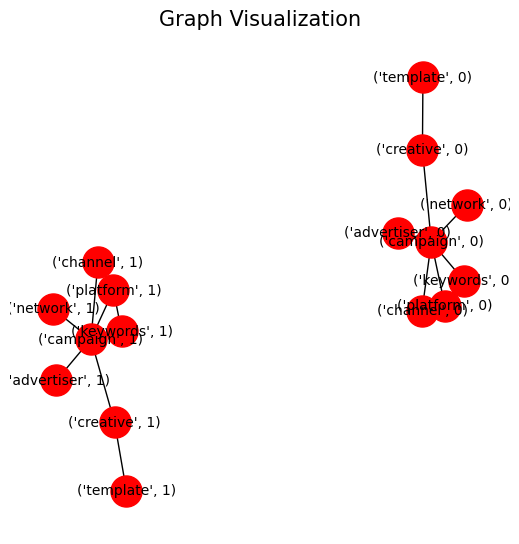

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import torch

def visualize_graph(data):
    # Create a new graph using NetworkX
    G = nx.Graph()

    # Add nodes and edges to the graph
    for edge_type, edge_index in data.edge_index_dict.items():
        src_type, _, dst_type = edge_type  # Extract source and destination node types
        for src, dst in edge_index.t().tolist():  # Add edges to the graph
            # Add nodes as (node_type, node_id)
            G.add_node((src_type, src))
            G.add_node((dst_type, dst))
            G.add_edge((src_type, src), (dst_type, dst))
    
    # Position nodes using the spring layout (force-directed layout)
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(5, 5))
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='red', font_size=10)
    plt.title("Graph Visualization", fontsize=15)
    plt.show()

# Visualize the graph
visualize_graph(data)


In [10]:
# Define the Heterogeneous GCN model
class HeteroGCN(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()

        # Define HeteroConv layer with SAGEConv for each relation
        self.conv1 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv(-1, hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv(-1, hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv(-1, hidden_dim),
            ('channel', 'rev_supports', 'channel'): SAGEConv(-1, hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv(-1, hidden_dim),
            ('creative', 'rev_uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv(-1, hidden_dim),
            ('template', 'rev_designed_with','creative'): SAGEConv(-1, hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_associated_with', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv(-1, hidden_dim),
            ('network', 'rev_managed_by', 'campaign'): SAGEConv(-1, hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_optimized_for', 'platform'): SAGEConv(-1, hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv(-1, hidden_dim),
            ('advertiser','rev_belongs_to','campaign'): SAGEConv(-1, hidden_dim)
        }, aggr="mean")

        self.conv2 = HeteroConv({
            ('campaign', 'hosted_on', 'platform'): SAGEConv(-1, hidden_dim),
            ('platform', 'rev_hosted_on', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'uses','channel'): SAGEConv(-1, hidden_dim),
            ('channel', 'rev_uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('platform', 'supports', 'channel'): SAGEConv(-1, hidden_dim),
            ('channel', 'rev_supports', 'channel'): SAGEConv(-1, hidden_dim),
            ('campaign', 'uses', 'creative'): SAGEConv(-1, hidden_dim),
            ('creative', 'rev_uses', 'campaign'): SAGEConv(-1, hidden_dim),
            ('creative', 'designed_with','template'): SAGEConv(-1, hidden_dim),
            ('template', 'rev_designed_with','creative'): SAGEConv(-1, hidden_dim),
            ('campaign', 'associated_with', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_associated_with', 'campaign'): SAGEConv(-1, hidden_dim),
            ('campaign', 'managed_by', 'network'): SAGEConv(-1, hidden_dim),
            ('network', 'rev_managed_by', 'campaign'): SAGEConv(-1, hidden_dim),
            ('platform', 'optimized_for', 'keywords'): SAGEConv(-1, hidden_dim),
            ('keywords', 'rev_optimized_for', 'platform'): SAGEConv(-1, hidden_dim),
            ('campaign','belongs_to','advertiser'): SAGEConv(-1, hidden_dim),
            ('advertiser','rev_belongs_to','campaign'): SAGEConv(-1, hidden_dim)
        }, aggr="mean")

        # Fully connected layer to produce a single output (click value)
        self.fc = torch.nn.Linear(hidden_dim * 8, 1)  # Concatenating features from 6 node types

        

    def forward(self, x_dict, edge_index_dict):

        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}  # Apply ReLU activation
        x_dict = self.conv2(x_dict, edge_index_dict)
        
        # Concatenate the features of campaign, platform, and channel for each record
        x_combined = torch.cat([x_dict['campaign'], x_dict['platform'],
                                x_dict['channel'], x_dict['creative'], 
                                x_dict['template'], x_dict['keywords'], 
                                x_dict['network'], x_dict['advertiser']], dim=1)
        
        # Pass through the fully connected layer to get the single click prediction
        out = self.fc(x_combined)
        
        return out

# Initialize model
model = HeteroGCN(hidden_dim=8)
print(model)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop for regression (click prediction)
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    out = model(data.x_dict, data.edge_index_dict)

    # Compute loss (MSE between predicted clicks and actual click values)
    loss = F.mse_loss(out.squeeze(), click_values)  # Ensure the shapes match

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch}, Loss: {loss.item():.4f}")





HeteroGCN(
  (conv1): HeteroConv(num_relations=18)
  (conv2): HeteroConv(num_relations=18)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Epoch 0, Loss: 413735.4688
Epoch 1, Loss: 132725.4062
Epoch 2, Loss: 70769.1641
Epoch 3, Loss: 101557.9844
Epoch 4, Loss: 134059.3125
Epoch 5, Loss: 136232.4062
Epoch 6, Loss: 118872.4844
Epoch 7, Loss: 97456.3125
Epoch 8, Loss: 80867.5469
Epoch 9, Loss: 72129.2891
Epoch 10, Loss: 70861.9062
Epoch 11, Loss: 74810.9688
Epoch 12, Loss: 80700.9766
Epoch 13, Loss: 85301.6484
Epoch 14, Loss: 86720.5391
Epoch 15, Loss: 84914.2031
Epoch 16, Loss: 81120.7109
Epoch 17, Loss: 76881.0312
Epoch 18, Loss: 73362.7031
Epoch 19, Loss: 71206.1406
Epoch 20, Loss: 70553.7969
Epoch 21, Loss: 71142.4062
Epoch 22, Loss: 72408.6562
Epoch 23, Loss: 73662.8359
Epoch 24, Loss: 74346.1094
Epoch 25, Loss: 74245.3281
Epoch 26, Loss: 73511.2812
Epoch 27, Loss: 72496.3438
Epoch 28, Loss: 71554.3438
Epoch 29, Loss: 70913.3203
Epoch 30, Loss: 70644.4688
Epoch 31, Loss: 

In [11]:
# Evaluation function
def evaluate_model(model, data, click_values, device='cpu'):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Forward pass
        out = model(data.x_dict, data.edge_index_dict)
        
        # Compute MSE loss between predictions and actual click values
        mse = F.mse_loss(out.squeeze(), click_values)  # Ensure the shapes match
        
        return mse.item()
    
# Evaluate the model on the same dataset or a separate test set
mse_score = evaluate_model(model, data, click_values)
print(f"Test MSE: {mse_score:.4f}")

Test MSE: 67282.9453


In [12]:
def r_squared(y_true, y_pred):
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    ss_res = ((y_true - y_pred) ** 2).sum()
    return 1 - (ss_res / ss_tot)

# Get predictions
predictions = model(data.x_dict, data.edge_index_dict).squeeze()

# Calculate R² score
r2_score = r_squared(click_values, predictions)
print(f"Test R²: {r2_score:.4f}")


Test R²: 0.0532


In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv

# Assuming your model is defined as 'model'
# and you've already prepared the new graph (with updated node features and edges)

# New data for prediction (single data point)
new_campaign = torch.tensor([[10, 3]], dtype=torch.float)  # Single new campaign feature (1 new campaign)

new_platform = torch.tensor([[150, 1, 0, 0]], dtype=torch.float)  # Single new platform feature (1 new platform)

new_channel = torch.tensor([[32, 1, 0, 0, 0, 0]], dtype=torch.float)  # Single new channel feature (1 new channel)

new_creative = torch.tensor([[1600, 0]], dtype=torch.float)  # Single new creative feature (1 new creative)

new_template = torch.tensor([[90]], dtype=torch.float)  # Single new template feature (1 new template)

new_network = torch.tensor([[190]], dtype=torch.float)  # Single new network feature (1 new network)

new_keywords = torch.rand((1, 50), dtype=torch.float)  # Single new keywords feature (1 new keywords)

new_advertiser = torch.rand((1, 51), dtype=torch.float)  # Single new advertiser feature (1 new advertiser)

# Add the new nodes and their features to the graph
data['campaign'].x = torch.cat([data['campaign'].x, new_campaign], dim=0)
data['platform'].x = torch.cat([data['platform'].x, new_platform], dim=0)
data['channel'].x = torch.cat([data['channel'].x, new_channel], dim=0)
data['creative'].x = torch.cat([data['creative'].x, new_creative], dim=0)
data['template'].x = torch.cat([data['template'].x, new_template], dim=0)
data['network'].x = torch.cat([data['network'].x, new_network], dim=0)
data['keywords'].x = torch.cat([data['keywords'].x, new_keywords], dim=0)
data['advertiser'].x = torch.cat([data['advertiser'].x, new_advertiser], dim=0)


# Prepare new edges if necessary (e.g., new connections between the new campaign and existing platforms, etc.)
# Example: adding edges for the new campaign (connect to existing platforms)
new_campaign_index = torch.tensor([data['campaign'].x.size(0) - 1])  # Index for the new campaign
new_platform_index = torch.tensor([0])  # Platform index to connect the new campaign to

data['campaign', 'hosted_on', 'platform'].edge_index = torch.cat(
    [
        data['campaign', 'hosted_on', 'platform'].edge_index, 
        torch.stack([new_campaign_index, new_platform_index], dim=0)
    ], dim=1
)


In [14]:
# Run model inference
model.eval()
with torch.no_grad():
    output = model(data.x_dict, data.edge_index_dict)

new_campaign_pred = output[-1]  # Assuming last row corresponds to the new campaign
print("Predicted clicks for new campaign:", new_campaign_pred.item())


Predicted clicks for new campaign: 5.436640739440918
